In [1]:
# Decompress the result files first to perform the data evaluation!

#############
#### HDU ####
#############

#############################
# Import simulation results #
#############################

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime

import numpy as np
import pandas as pd
import glob as gb
from buildingspy.io.outputfile import Reader

# set working directory and results file path
#path_dir = 'roofkit/Resources/EvaluationResults/'
path_dir = 'C:/Users/vp3411/Documents/Programme/Modelica/RoofKIT/roofkit/Resources/EvaluationResults/'
os.chdir(path_dir)
path_res = (path_dir+'HDU_D6.mat')
r=Reader(path_res, "dymola")

# load simulation time and save as datetime object 
time = r.values(u'pVSimpleOriented.P')[0] 
time_dt = pd.to_datetime(time, unit='s', yearfirst=2021)

## List of variables in the simulation
# outdoor temperature -> HDU.y[1]
# Indoor temperature -> HDU.y[4]
# heating energy -> HDU.y[3]
# electrical energy -> HDU.y[9]
# total thermal energy heat pump -> heaPum.QLoa_flow
# total electrical energy heat pump -> heaPum.P
# Total energy consumption -> add_pow.y 
# Total energy generated PV -> pVSimpleOriented.P
# time -> calTim

# Import the results the evaluate the HDU energy performance
ix = np.arange(0,31536001,3600)
energy_df = pd.DataFrame({'Time': time, 
                          'EE_total': r.values(u'power_total.y')[1], 
                          'EE_heatPump': r.values(u'heaPum.P')[1], 
                          'EE_vent': r.values(u'vent_power.y')[1], 
                          'EE_PV': r.values(u'pVSimpleOriented.P')[1], 
                          'EE_house': r.values(u'HDU.y[9]')[1], 
                          'EE_grid': r.values(u'grid.P.real')[1],
                          'Q_heatPump': r.values(u'heaPum.P')[1],
                          'COP_heatPump': r.values(u'heaPum.COP')[1],
                          'Heating': r.values(u'HDU.y[3]')[1], 
                          'OutTemp': r.values(u'HDU.y[1]')[1], 
                          'IndTemp': r.values(u'HDU.y[4]')[1], 
                          'DHW': r.values(u'HDU.y[10]')[1],
                          'Month': r.values(u'calTim.month')[1]}, 
                 columns=['Time', 'EE_total', 'EE_heatPump','EE_vent','EE_PV',
                 'EE_house', 'EE_grid', 'Q_heatPump','COP_heatPump', 'Heating', 'OutTemp',
                 'IndTemp', 'DHW', 'Month'])

# remove duplicate time values and add date index
energy_df.index = time_dt
energy_df = energy_df[~energy_df.index.duplicated(keep='first')]

# Import the files to evaluate the performance of the solar collectors
solarcol_df = pd.DataFrame({'Time': time, 
                          'Coll_In_T': r.values(u'Temp_In_solCol.T')[1], 
                          'Coll_Out_T': r.values(u'Temp_Out_solCol.T')[1], 
                          'Month': r.values(u'calTim.month')[1]}, 
                 columns=['Time', 'Coll_In_T','Coll_Out_T','Month', 'Coll_mflow'])

solarcol_df.index = time_dt
solarcol_df = solarcol_df[~solarcol_df.index.duplicated(keep='first')]
#solarcol_df = solarcol_df.resample('H').mean()
solarcol_mflow = 12 * 60 / 3600 # 60 l/h flowing through solar collectors

# Import Simroom simulation results
simroom_df = pd.DataFrame({'Q_solar': [1.76,4.4,5.69,6.38,5.27,3.87,4.16,3.86,2.88,2.82,1.45,1.19], 
                          'Q_internal': [5.46,4.93,5.46,5.29,5.46,5.29,5.46,5.46,5.29,5.46,5.29,5.47], 
                          'Q_transmission': [-12.75,-12.54,-12.23,-10.31,-7.65,-5.92,-4.92,-4.64,-6.31,-7.91,-10.37,-12.54], 
                          'Q_heating': [6.74,4.5,2.44,0.09,0.04,0,0,0,0,0.39,4.61,7.1], 
                          'Q_ventilation': [-1.16,-1.13,-1.09,-1.17,-2.72,-3.05,-4.52,-4.52,-1.86,-0.76,-0.94,-1.14]}, 
                 columns=['Q_solar', 'Q_internal','Q_transmission','Q_heating','Q_ventilation'])

# Import results for indoor comfort evaluation
path_comf = (path_dir+'220301_SimRoom_results_comfort.xlsx')
comf_df = pd.read_excel(path_comf, index_col=0)
temp_range = np.arange(10,30,1)
temp_range_low = np.arange(-5,10.5,1)

In [3]:
################################
# Perform results calculations #
################################

# Energy indicators - real values modelica results evaluation
# EE generated -> 3224.2
# EE consumed -> 3424.28
# EE consumed house -> 2390.38
# EE grid -> 1342.1 EE_grid
# Th heat pump -> 2571.35
# Isc -> 0.85
# JAZ 2.503

hdu_area = 54 #area of HDU

def monthly_sum(var, var_time):
    '''
    Function to calculate monthly values using time integration
    Simulation results have hourly values, therefore the basis dt is 3600 s
    '''
    data_house = energy_df['EE_house'].resample('M').sum()/1000
    result = np.zeros(12)

    for i in range(0,12):
        # filter data
        var_month = var[var.index.month==(i+1)]
        dt = var_time.diff()[var_time.index.month == (i+1)]

        # calculate monthy values by integrating over time
        result[i] = (var_month[0]+(var_month[1:]*dt[1:]/3600).sum())/1000/hdu_area

    return result

## Energy monthly values
# Total electrical energy consumption
data_ee_total = pd.Series(monthly_sum(energy_df.EE_total, energy_df.Time),
    index=energy_df.resample('M').sum().index[:-1])

# Appliances and usage energy consumption
data_house = pd.Series(monthly_sum(energy_df.EE_house, energy_df.Time),
    index=energy_df.resample('M').sum().index[:-1])

# Heat pump energy consumption
data_hp = data_ee_total - data_house

# PV energy generation 
data_pv = pd.Series(monthly_sum(energy_df.EE_PV, energy_df.Time),
    index=energy_df.resample('M').sum().index[:-1])

# Energy fed into the grid
e_grid = energy_df['EE_grid'].copy()
e_grid[e_grid>0] = 0

data_grid = pd.Series(monthly_sum(e_grid, energy_df.Time),
    index=energy_df.resample('M').sum().index[:-1])

e_pv_filt = energy_df['EE_PV']
e_pv_filt[e_pv_filt<0.1] = 0.1

e_gen_net = (energy_df['EE_PV'] + e_grid)

# Self-consumption indicator
i_sc = np.multiply(e_gen_net,1/e_pv_filt).resample('M').mean()[:-1]

# HDU heating load
data_heating = simroom_df['Q_heating']

#HDU hot water consumption
energy_dhw = energy_df['DHW']/3600*4200*30
data_dhw = pd.Series(monthly_sum(energy_dhw, energy_df.Time),
                        index=energy_df.resample('M').sum().index[:-1])

# Thermal energy heat pump
data_hp_th = pd.Series(monthly_sum(energy_df.Q_heatPump, energy_df.Time),
    index=energy_df.resample('M').sum().index[:-1])

# Thermal output solar collector field
energy_solCol = solarcol_mflow*4200*(solarcol_df['Coll_Out_T']-solarcol_df['Coll_In_T'])
data_solCol = pd.Series(monthly_sum(energy_solCol, energy_df.Time),
                          index=energy_df.resample('M').sum().index[:-1])



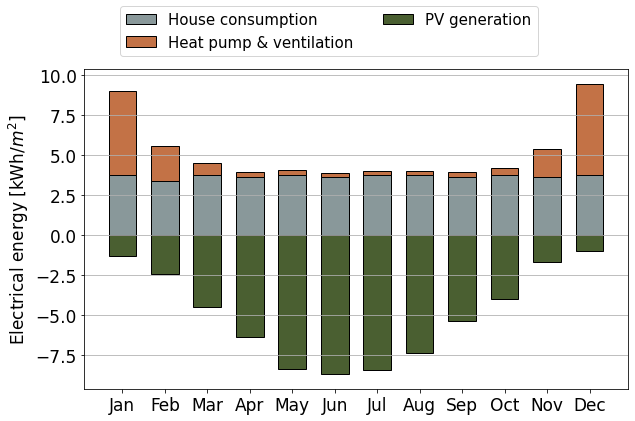

In [4]:
####################
# Plot the results #
####################
# Array of colors according to RoofKIT color code
colarray = ['#89989A', '#C37246', '#4A5F31', '#4653A5', '#E2B01F', '#000000']

# Electrical energy plot
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.10, top = 0.84,
                    left = 0.13, right = 0.97,
                    wspace=0.2, hspace = 0.5) 
ax.yaxis.grid()
for i in range(len(data_house)):      
    ax.bar(range(len(data_house))[i], 
        data_house[i], 
        width = 0.65,
        facecolor = colarray[0],
        edgecolor = 'black')
    ax.bar(range(len(data_hp))[i], 
        data_hp[i], 
        width = 0.65,
        facecolor = colarray[1],
        edgecolor = 'black',
        bottom = data_house[i])
    ax.bar(range(len(data_hp))[i], 
        data_pv[i]*-1, 
        width = 0.65,
        facecolor = colarray[2],
        edgecolor = 'black')

ax.xaxis.set_ticks(np.arange(0,len(data_house)))
ax.set_xticklabels(data_house.index.strftime('%b'), fontsize = 17)
ax.legend(['House consumption', 'Heat pump & ventilation', 'PV generation'], 
        fontsize = 15, ncol=2 , loc='upper center', 
        bbox_to_anchor=(0.45, 1.22), framealpha = 0.8)
ax.set_ylabel('Electrical energy [kWh/$m^2$]', fontsize=17)
ax.tick_params(labelsize = 17)


(-9.0, 11.0)

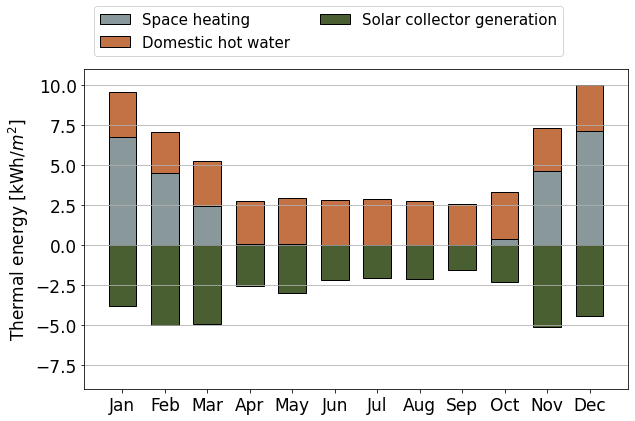

In [5]:
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.10, top = 0.84,
                    left = 0.13, right = 0.97,
                    wspace=0.2, hspace = 0.5) 
ax.yaxis.grid()
for i in range(len(data_dhw)):      
    ax.bar(range(len(data_heating))[i], 
        data_heating[i], 
        width = 0.65,
        facecolor = colarray[0],
        edgecolor = 'black')
    ax.bar(range(len(data_dhw))[i], 
        data_dhw[i], 
        width = 0.65,
        facecolor = colarray[1],
        edgecolor = 'black',
        bottom = data_heating[i])
    ax.bar(range(len(data_solCol))[i], 
        data_solCol[i]*-1, 
        width = 0.65,
        facecolor = colarray[2],
        edgecolor = 'black')

ax.xaxis.set_ticks(np.arange(0,len(data_dhw)))
ax.set_xticklabels(data_dhw.index.strftime('%b'), fontsize = 17)
ax.legend(['Space heating', 'Domestic hot water', 'Solar collector generation'], 
        fontsize = 15, ncol=2 , loc='upper center', 
        bbox_to_anchor=(0.45, 1.22), framealpha = 0.8)
ax.set_ylabel('Thermal energy [kWh/$m^2$]', fontsize=17)
ax.tick_params(labelsize = 17)
ax.set_ylim([-9,11])

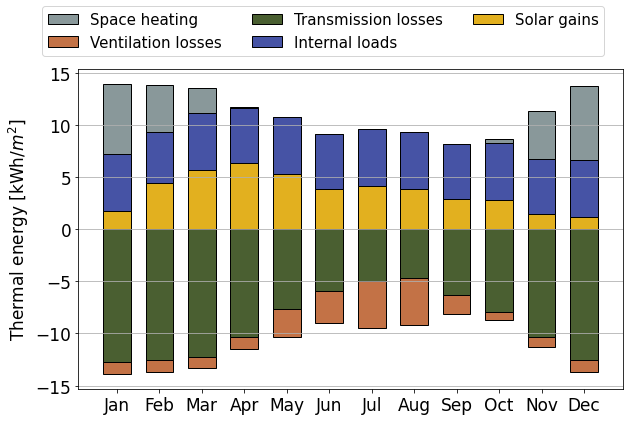

In [6]:
# Energy balance
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.10, top = 0.84,
                    left = 0.13, right = 0.97,
                    wspace=0.2, hspace = 0.5) 
ax.yaxis.grid()
for i in range(len(simroom_df)):      
    ax.bar(range(len(simroom_df['Q_heating']))[i], 
        simroom_df['Q_heating'][i], 
        width = 0.65,
        facecolor = colarray[0],
        edgecolor = 'black',
        bottom = simroom_df['Q_solar'][i]+simroom_df['Q_internal'][i])
    ax.bar(range(len(simroom_df['Q_ventilation']))[i], 
        simroom_df['Q_ventilation'][i], 
        width = 0.65,
        facecolor = colarray[1],
        edgecolor = 'black',
        bottom = simroom_df['Q_transmission'][i])
    ax.bar(range(len(simroom_df['Q_transmission']))[i], 
        simroom_df['Q_transmission'][i], 
        width = 0.65,
        facecolor = colarray[2],
        edgecolor = 'black')
    ax.bar(range(len(simroom_df['Q_internal']))[i], 
        simroom_df['Q_internal'][i], 
        width = 0.65,
        facecolor = colarray[3],
        edgecolor = 'black',
        bottom = simroom_df['Q_solar'][i])
    ax.bar(range(len(simroom_df['Q_solar']))[i], 
        simroom_df['Q_solar'][i], 
        width = 0.65,
        facecolor = colarray[4],
        edgecolor = 'black')
ax.xaxis.set_ticks(np.arange(0,len(data_dhw)))
ax.set_xticklabels(data_dhw.index.strftime('%b'), fontsize = 17)
ax.legend(['Space heating', 'Ventilation losses', 'Transmission losses',
        'Internal loads', 'Solar gains'], 
        fontsize = 15, ncol=3 , loc='upper center', 
        bbox_to_anchor=(0.45, 1.22), framealpha = 0.8)
ax.set_ylabel('Thermal energy [kWh/$m^2$]', fontsize=17)
ax.tick_params(labelsize = 17)

Text(0, 0.5, 'Self-consumption index[-]')

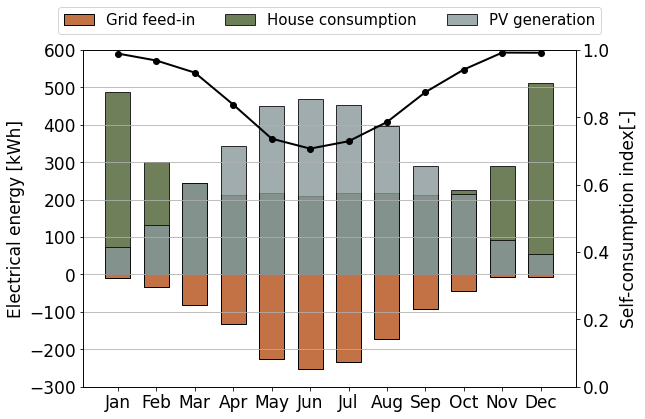

In [7]:
# Self-consumption plot
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.10, top = 0.88,
                    left = 0.13, right = 0.89,
                    wspace=0.2, hspace = 0.5) 
ax.yaxis.grid()
for i in range(len(data_ee_total)):      
    ax.bar(range(len(data_grid)+1)[i], 
        data_grid[i]*hdu_area, 
        width = 0.65,
        facecolor = colarray[1],
        edgecolor = 'black')
    ax.bar(range(len(data_grid)+1)[i], 
        data_ee_total[i]*hdu_area, 
        width = 0.65,
        facecolor = colarray[2],
        edgecolor = 'black',
        alpha = 0.8)
    ax.bar(range(len(data_grid)+1)[i], 
        data_pv[i]*hdu_area, 
        width = 0.65,
        facecolor = colarray[0],
        edgecolor = 'black',
        alpha = 0.8)

ax2 = ax.twinx()
ax2.plot(np.arange(0,len(data_grid)),i_sc, '-ko', linewidth = 2, label = "SC")
ax.xaxis.set_ticks(np.arange(0,len(data_grid)))
ax.set_xticklabels(data_grid.index.strftime('%b'), fontsize = 17)
ax.legend(['Grid feed-in', 'House consumption', 'PV generation'], 
        fontsize = 15, ncol=3 , loc='upper center', 
        bbox_to_anchor=(0.5, 1.15), framealpha = 0.8)
ax.set_ylabel('Electrical energy [kWh]', fontsize=17)
ax.tick_params(labelsize = 17)
ax.set_ylim([-300,600])
ax2.set_ylim([0,1])
ax2.tick_params(labelsize = 17)
ax2.set_ylabel('Self-consumption index[-]', fontsize=17, labelpad = 10)


(16.0, 32.0)

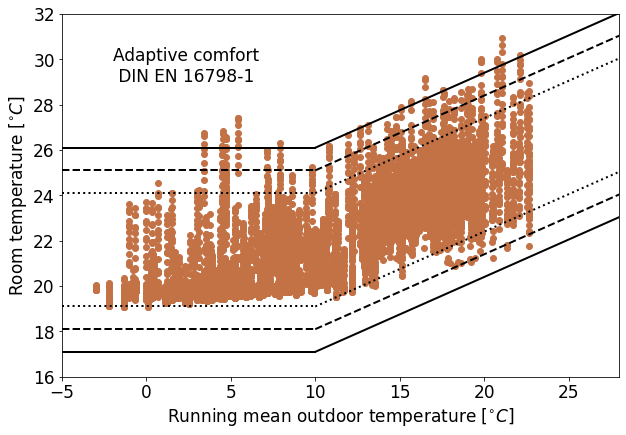

In [8]:
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.12, top = 0.96,
                    left = 0.11, right = 0.97) 
ax.annotate('Adaptive comfort\n DIN EN 16798-1', [-2,29], fontsize=17)
ax.scatter(comf_df['Te_gl.Mittel'], comf_df['Raumtemperatur'], c=colarray[1])

ax.plot(temp_range, temp_range*0.33+18.8+2, 'k:', linewidth = 2, label = "PD = 10%")
ax.plot(temp_range, temp_range*0.33+18.8+3, 'k--', linewidth = 2, label = "PD = 20%")   
ax.plot(temp_range, temp_range*0.33+18.8+4, 'k-', linewidth = 2, label = "PD = 30%")
ax.plot(temp_range, temp_range*0.33+18.8-3, 'k:', linewidth = 2, label = "PD = 10%")
ax.plot(temp_range, temp_range*0.33+18.8-4, 'k--', linewidth = 2, label = "PD = 20%")   
ax.plot(temp_range, temp_range*0.33+18.8-5, 'k-', linewidth = 2, label = "PD = 30%")
ax.plot(temp_range_low, np.repeat(10*0.33+18.8+2,len(temp_range_low)), 'k:', linewidth = 2, label = "PD = 10%")
ax.plot(temp_range_low, np.repeat(10*0.33+18.8+3,len(temp_range_low)), 'k--', linewidth = 2, label = "PD = 20%")   
ax.plot(temp_range_low, np.repeat(10*0.33+18.8+4,len(temp_range_low)), 'k-', linewidth = 2, label = "PD = 30%")
ax.plot(temp_range_low, np.repeat(10*0.33+18.8-3,len(temp_range_low)), 'k:', linewidth = 2, label = "PD = 10%")
ax.plot(temp_range_low, np.repeat(10*0.33+18.8-4,len(temp_range_low)), 'k--', linewidth = 2, label = "PD = 20%")   
ax.plot(temp_range_low, np.repeat(10*0.33+18.8-5,len(temp_range_low)), 'k-', linewidth = 2, label = "PD = 30%")

ax.set_ylabel('Room temperature [$^{\circ}C$]', fontsize=17)
ax.set_xlabel('Running mean outdoor temperature [$^{\circ}C$]', fontsize=17)
ax.tick_params(labelsize = 17)
ax.set_xlim([-5,28])     
ax.set_ylim([16,32])     

In [18]:
#############
# Factsheet #
#############

# Monthly values 
print('Heating energy thermal')
print(data_heating*hdu_area)

print('DHW energy thermal')
print(data_dhw*hdu_area)

print('DHW energy electrical')
print(np.multiply(data_hp.values,(data_dhw.values/(data_dhw.values+data_heating)))*hdu_area)

# Assumption -> ventilation systems work an average of 3 hours a day
data_vent = (0.33**3 * 3.3 * 4 + 6.2 * 3 / 3/24)
daysmonth = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
print('Ventilation electrical energy - annual')
print(data_vent*daysmonth*24/1000)

print('Other auxiliary - 1$%$ EE heatpump')
print(data_hp*0.01*hdu_area)

print('Usage related')
print((data_house - data_hp*0.01)*hdu_area)

# Assumption -> 8 km/Day - 80 km / charge - 410 Wh/charge
print('Mobility')
print(daysmonth/8*410/1000)

print('PV Generation')
print(data_pv*54)

# Assumption -> daily total hours of light usage (2.35) according to EN 16798-1
data_light = 2.35*456
print('Lighting')
print(data_light*daysmonth/1000)

print('Self-consumption')
print(i_sc)

Heating energy thermal
0     363.96
1     243.00
2     131.76
3       4.86
4       2.16
5       0.00
6       0.00
7       0.00
8       0.00
9      21.06
10    248.94
11    383.40
Name: Q_heating, dtype: float64
DHW energy thermal
1970-01-31    154.132267
1970-02-28    139.539524
1970-03-31    151.828194
1970-04-30    142.565286
1970-05-31    155.874318
1970-06-30    150.220548
1970-07-31    155.054659
1970-08-31    149.673184
1970-09-30    138.189353
1970-10-31    159.191458
1970-11-30    145.855961
1970-12-31    156.309556
Freq: M, dtype: float64
DHW energy electrical
0     84.548071
1     43.036682
2     22.053629
3     15.837615
4     15.687307
5     14.256860
6     14.476626
7     14.539956
8     16.519442
9     21.761410
10    34.789308
11    88.838855
Name: Q_heating, dtype: float64
Ventilation electrical energy - annual
[0.54513009 0.49237556 0.54513009 0.52754525 0.54513009 0.52754525
 0.54513009 0.54513009 0.52754525 0.54513009 0.52754525 0.54513009]
Other auxiliary - 1$%$ EE 

In [22]:
#############################
# Import simulation results #
#############################
path_gg = (path_dir+'GG_D6_simplified.mat')
g=Reader(path_gg, "dymola")

time = g.values(u'PV_sum.y')[0] 
time_dt = pd.to_datetime(time, unit='s', yearfirst=2021)

# List of variables from the simulation
# outdoor temperature -> HDU.y[1]
# Indoor temperature -> HDU.y[4]
# heating energy -> HDU.y[3]
# electrical energy -> HDU.y[9]
# total thermal energy heat pump -> heaPum.QLoa_flow
# total electrical energy heat pump -> heaPum.P
# Total energy consumption -> add_pow.y 
# Total energy generated PV -> pVSimpleOriented.P
# time -> calTim

ix = np.arange(0,31536001,3600)
GG_df = pd.DataFrame({'Time': time, 
                    'EE_total': g.values(u'PV_sum.y')[1], 
                    'EE_dach': g.values(u'PV_Dach.P')[1], 
                    'EE_fas_W': g.values(u'PV_Fass_West.P')[1], 
                    'EE_fas_O': g.values(u'PV_Fass_Ost.P')[1], 
                    'EE_fas_S': g.values(u'PV_Fass_Sued.P')[1], 
                    'EE_grid': g.values(u'grid.P.real')[1],
                    'EE_heatpump': g.values(u'division.y')[1],
                    'Mobility': np.ones_like(g.values(u'add.y')[1])*158.5365,
                    'Heating': g.values(u'Heat_sum.y')[1], 
                    'Ventilation': g.values(u'Vent_SPF.y')[1], 
                    'Greywater': g.values(u'greywater_rec.y')[1], 
                    'Electric': g.values(u'EE_house.y')[1], 
                    'DHW_load': g.values(u'DHW_energy.y')[1], 
                    'DHW_net': g.values(u'add1.y')[1]}, 
                columns=['Time', 'EE_total', 'EE_dach','EE_fas_W','EE_fas_O',
                'EE_fas_S', 'EE_grid','EE_heatpump', 'Mobility', 'Heating', 
                'Ventilation', 'Greywater', 'Electric','DHW_load','DHW_net'])

GG_df.index = time_dt
GG_df = GG_df[~GG_df.index.duplicated(keep='first')]
GG_df = GG_df.resample('H').mean()


In [23]:
################################
# Perform results calculations #
################################

# Monthly values 
# Whole building electrical energy consumption
GG_df['House_EL'] = GG_df['Electric'] - GG_df['EE_heatpump']*0.01 - GG_df['Mobility']

# Total building area in m2
gg_area = 1732.62

# Distribute heat pump electrical energy consumption into space heating and DHW
heatpump_dhw = (np.multiply(GG_df['EE_heatpump'].resample('M').sum()*0.99/1000,
    (GG_df['DHW_load'].resample('M').sum().values/1000/(GG_df['DHW_load'].resample('M').sum().values/1000+GG_df['Heating'].resample('M').sum().values/1000))))
heatpump_heat = GG_df['EE_heatpump'].resample('M').sum()*0.99/1000 - heatpump_dhw

# Sum of onsite PV generation modules
pv_onsite = GG_df['EE_dach'].resample('M').sum()/1000+\
            GG_df['EE_fas_W'].resample('M').sum()/1000+\
            GG_df['EE_fas_O'].resample('M').sum()/1000+\
            GG_df['EE_fas_S'].resample('M').sum()/1000

# Self-consummption
grid_fed_in = GG_df['EE_grid'].copy()
grid_fed_in[grid_fed_in>0] = 0
grid_fed_in = grid_fed_in*-1
gg_grid_fed = (GG_df['EE_total'] - grid_fed_in)/GG_df['EE_total']

In [24]:
#############
# Factsheet #
#############

print('Heating energy')
print(GG_df['Heating'].resample('M').sum()/1000)

print('DHW energy')
print(GG_df['DHW_load'].resample('M').sum()/1000)

print('Heat pump electrical')
print(GG_df['EE_heatpump'].resample('M').sum()*0.99/1000)

print('Heat pump electrical for heating')
print(heatpump_heat)

print('Heat pump electrical for dhw')
print(heatpump_dhw)

print('Ventilation energy')
print(GG_df['Ventilation'].resample('M').sum()/1000)

print('Other auxiliary - 1$%$ EE heatpump')
print(GG_df['EE_heatpump'].resample('M').sum()/1000*0.01)

print('Usage related')
print(GG_df['House_EL'].resample('M').sum()/1000) 

print('Mobility')
print(GG_df['Mobility'].resample('M').sum()/1000)

# Greywater heat recovery -> 20% assumed
print('Greywater energy recovery')
print(GG_df['Greywater'].resample('M').sum()/1000)

print('PV Generation on site')
print(pv_onsite)

print('PV Generation nearby')
print(GG_df['EE_total'].resample('M').sum()/1000 - pv_onsite)

print('Self-consumption')
print(gg_grid_fed.resample('M').mean())



Heating energy
1970-01-31    1475.253630
1970-02-28    1686.390665
1970-03-31     978.749738
1970-04-30      45.421342
1970-05-31      30.921393
1970-06-30      31.034417
1970-07-31      32.912175
1970-08-31      32.542108
1970-09-30      29.867650
1970-10-31      30.035883
1970-11-30     586.066636
1970-12-31    1740.664262
1971-01-31       4.861910
Freq: M, Name: Heating, dtype: float64
DHW energy
1970-01-31    3587.443178
1970-02-28    3244.897101
1970-03-31    3616.346180
1970-04-30    3514.645012
1970-05-31    3662.932787
1970-06-30    3536.026446
1970-07-31    3699.550839
1970-08-31    3710.278805
1970-09-30    3540.197101
1970-10-31    3631.202767
1970-11-30    3483.383095
1970-12-31    3622.019979
1971-01-31       3.951850
Freq: M, Name: DHW_load, dtype: float64
Heat pump electrical
1970-01-31    1717.519544
1970-02-28    1599.805759
1970-03-31    1093.340269
1970-04-30     578.438850
1970-05-31     563.905117
1970-06-30     517.597261
1970-07-31     538.659512
1970-08-31     5

In [25]:
####################
# Plot the results #
####################

# Load individual floor data
path_gg_raw = ('C:/Users/vp3411/Documents/Programme/Modelica/RoofKIT/roofkit/Resources/BuildingData/GG/*.txt')
pathlist_gg_raw = gb.glob(path_gg_raw)

data_gg_raw = {}
for i in range(0,len(pathlist_gg_raw)-1):
    data_gg_raw[i] = pd.read_csv(pathlist_gg_raw[i+1], 
                                 sep="\t", 
                                 skiprows=2)
    data_gg_raw[i].columns = ['Time','T_air','P_heat','TWW','Electr','Ventilation']
    data_gg_raw[i].Time = data_gg_raw[i].Time - 3600
    data_gg_raw[i] = data_gg_raw[i].loc[0:8759]
    data_gg_raw[i].index = pd.to_datetime(data_gg_raw[i].Time, unit='s', yearfirst=2021)
area1 = 741
area2 = 991.6

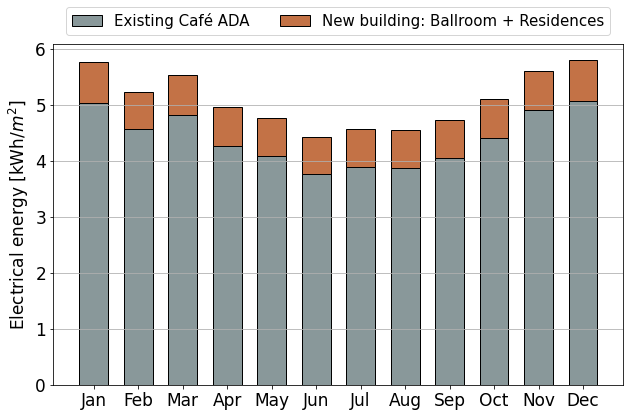

In [26]:
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.10, top = 0.89,
                    left = 0.09, right = 0.97,
                    wspace=0.2, hspace = 0.5) 
ax.yaxis.grid()
ax.bar(np.arange(0,len(data_gg_raw[0].resample('M').sum())), 
    data_gg_raw[0].Electr.resample('M').sum()/gg_area/1000, 
    width = 0.65,
    facecolor = colarray[0],
    edgecolor = 'black')
ax.bar(np.arange(0,len(data_gg_raw[0].resample('M').sum())), 
    (data_gg_raw[1].Electr.resample('M').sum()+data_gg_raw[2].Electr.resample('M').sum())/gg_area/1000, 
    width = 0.65,
    facecolor = colarray[1],
    edgecolor = 'black',
    bottom = data_gg_raw[0].Electr.resample('M').sum()/gg_area/1000)

ax.xaxis.set_ticks(np.arange(0,len(data_gg_raw[0].resample('M').sum())))
ax.set_xticklabels(data_gg_raw[0].resample('M').sum().index.strftime('%b'), fontsize = 17)
ax.legend(['Existing Café ADA', 'New building: Ballroom + Residences'], 
        fontsize = 15, ncol=2 , loc='upper center', 
        bbox_to_anchor=(0.5, 1.13), framealpha = 0.8)
ax.set_ylabel('Electrical energy [kWh/$m^2$]', fontsize=17)
ax.tick_params(labelsize = 17)


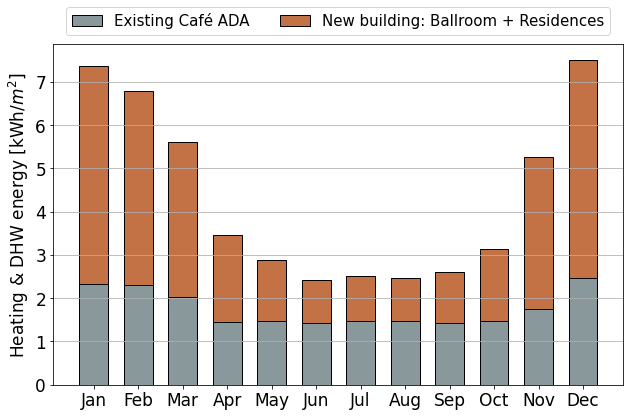

In [27]:
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.10, top = 0.89,
                    left = 0.09, right = 0.97,
                    wspace=0.2, hspace = 0.5) 
ax.yaxis.grid()
ax.bar(np.arange(0,len(data_gg_raw[0].resample('M').sum())), 
    data_gg_raw[0].P_heat.resample('M').sum()/gg_area/1000+data_gg_raw[0].TWW.resample('M').sum()/gg_area/1000*4200 * 30 / 3600, 
    width = 0.65,
    facecolor = colarray[0],
    edgecolor = 'black')
ax.bar(np.arange(0,len(data_gg_raw[0].resample('M').sum())), 
    (data_gg_raw[1].P_heat.resample('M').sum()+ \
     data_gg_raw[1].TWW.resample('M').sum()*4200 * 30 / 3600+\
     data_gg_raw[2].P_heat.resample('M').sum()+\
     data_gg_raw[2].TWW.resample('M').sum()*4200 * 30 / 3600)/gg_area/1000, 
    width = 0.65,
    facecolor = colarray[1],
    edgecolor = 'black',
    bottom = data_gg_raw[0].P_heat.resample('M').sum()/gg_area/1000+data_gg_raw[0].TWW.resample('M').sum()/gg_area/1000*4200*30/3600)

ax.xaxis.set_ticks(np.arange(0,len(data_gg_raw[0].resample('M').sum())))
ax.set_xticklabels(data_gg_raw[0].resample('M').sum().index.strftime('%b'), fontsize = 17)
ax.legend(['Existing Café ADA', 'New building: Ballroom + Residences'], 
        fontsize = 15, ncol=2 , loc='upper center', 
        bbox_to_anchor=(0.5, 1.13), framealpha = 0.8)
ax.set_ylabel('Heating & DHW energy [kWh/$m^2$]', fontsize=17)
ax.tick_params(labelsize = 17)

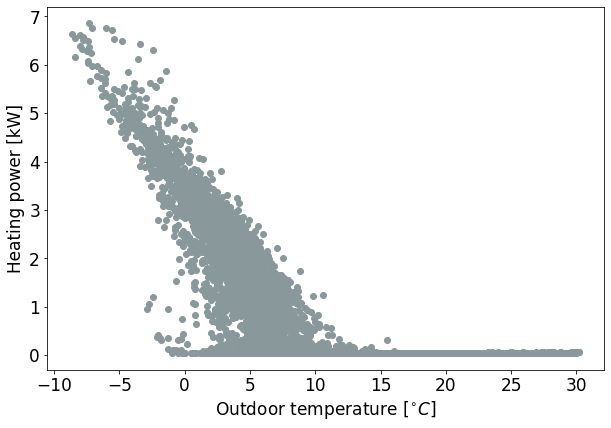

In [35]:
# Energy signature model
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.12, top = 0.96,
                    left = 0.11, right = 0.97) 
ax.scatter(energy_df.OutTemp.resample('H').mean(), GG_df['Heating']/1000, c=colarray[0])

ax.set_ylabel('Heating power [kW]', fontsize=17)
ax.set_xlabel('Outdoor temperature [$^{\circ}C$]', fontsize=17)
ax.tick_params(labelsize = 17)

Text(0, 0.5, 'Self-consumption index[-]')

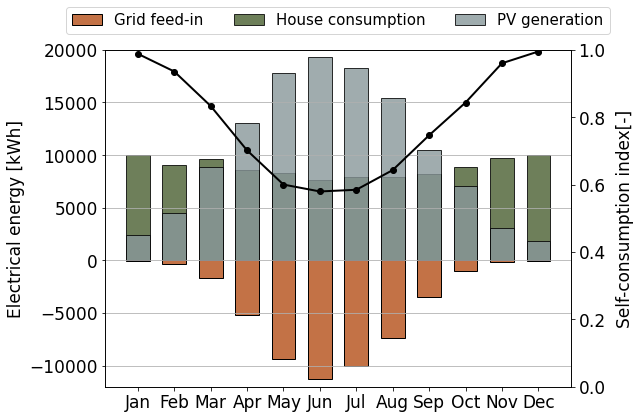

In [36]:
fig, ax = plt.subplots(figsize=[9,6])
plt.subplots_adjust(bottom=0.10, top = 0.88,
                    left = 0.17, right = 0.89,
                    wspace=0.2, hspace = 0.5) 
ax.yaxis.grid()
ax.bar(range(len(grid_fed_in.resample('M').sum()[:-1])), 
    grid_fed_in.resample('M').sum()[:-1]/1000*-1,
    width = 0.65,
    facecolor = colarray[1],
    edgecolor = 'black')
ax.bar(range(len(grid_fed_in.resample('M').sum()[:-1])), 
    (data_gg_raw[0].Electr.resample('M').sum()+data_gg_raw[1].Electr.resample('M').sum()+data_gg_raw[2].Electr.resample('M').sum())/1000, 
    width = 0.65,
    facecolor = colarray[2],
    edgecolor = 'black',
    alpha = 0.8)
ax.bar(range(len(grid_fed_in.resample('M').sum()[:-1])), 
    GG_df['EE_total'].resample('M').sum()[:-1]/1000, 
    width = 0.65,
    facecolor = colarray[0],
    edgecolor = 'black',
    alpha = 0.8)

ax2 = ax.twinx()
ax2.plot(np.arange(0,len(data_grid)),gg_grid_fed.resample('M').mean()[:-1], 
         '-ko', linewidth = 2, label = "SC")

ax.xaxis.set_ticks(np.arange(0,len(data_grid)))
ax.set_xticklabels(data_grid.index.strftime('%b'), fontsize = 17)
ax.legend(['Grid feed-in', 'House consumption', 'PV generation'], 
        fontsize = 15, ncol=3 , loc='upper center', 
        bbox_to_anchor=(0.5, 1.15), framealpha = 0.8)
ax.set_ylabel('Electrical energy [kWh]', fontsize=17)
ax.tick_params(labelsize = 17)
ax.set_ylim([-12000,20000])
ax2.set_ylim([0,1])
ax2.tick_params(labelsize = 17)
ax2.set_ylabel('Self-consumption index[-]', fontsize=17, labelpad = 10)
